✅ 1. Setup: Prioritize Local src/ Directory for Imports

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

from model_eval import evaluate_model
from resampling import (
    manual_upsampling, smote, adasyn, borderline_smote,
    smote_tomek, smote_enn, random_undersample, cluster_centroids
)

✅ 2. Define Resamplers

In [4]:
# 📦 Standard setup: load, split, and prep data
from preprocessing import load_and_prepare_data, split_and_scale, select_top_features

# 📂 Path to your dataset
data_path = "../data/synth_rare_event_data.csv"
target_col = "rare_event"

# 🧼 Load and prepare
X, y = load_and_prepare_data(data_path, target_col)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)
X_train, X_test, _ = select_top_features(X_train_scaled, y_train, X_test_scaled, return_features=True)

In [6]:
# 📊 Define resampling strategies
resamplers = {
    "Manual Upsampling": lambda: manual_upsampling(X_train, y_train, target_col),
    "SMOTE": lambda: smote(X_train, y_train),
    "ADASYN": lambda: adasyn(X_train, y_train),
    "Borderline SMOTE": lambda: borderline_smote(X_train, y_train),
    "SMOTETomek": lambda: smote_tomek(X_train, y_train),
    "SMOTEENN": lambda: smote_enn(X_train, y_train),
    "Random Undersample": lambda: random_undersample(X_train, y_train),
    "Cluster Centroids": lambda: cluster_centroids(X_train, y_train),
    "No Resampling": lambda: (X_train, y_train)
}

✅ 3. Copy-Paste This Cell: Breed and Battle Implementation

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import random

def make_child_model(params):
    return LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=params["l1_ratio"],
        C=params["C"],
        max_iter=2000,
        tol=1e-4,
        class_weight='balanced',
        random_state=42
    )

def mutate_params(base_params, noise=0.1):
    return {
        "C": max(0.01, base_params["C"] + np.random.uniform(-noise, noise)),
        "l1_ratio": min(1.0, max(0.0, base_params["l1_ratio"] + np.random.uniform(-noise, noise)))
    }

def print_fighter_intro(f):
    print(f"\n👊 {f['label']} enters the arena!")
    print(f"📍 Style: {f['resampling']}")
    print(f"🧬 Genome: C = {f['params']['C']:.2f}, l1_ratio = {f['params']['l1_ratio']:.2f}")
    print(f"🔁 Generation: {f['generation']}")
    print(f"🏆 Last Score: PR AUC = {f['score']['pr_auc']:.3f}")
    if 'parent' in f:
        print(f"🧬 Lineage: child of {f['parent']} (Gen {f['generation'] - 1})")

def breed_and_battle(resampled_datasets, X_test, y_test, generations=3, top_k=3):
    population = []
    gen = 0

    # Generation 0: Initial fighters
    for label, (X_res, y_res) in resampled_datasets.items():
        base_params = {"C": 1.0, "l1_ratio": 0.5}
        model = make_child_model(base_params)
        model.fit(X_res, y_res)
        score = evaluate_model(model, X_test, y_test, label=label, return_scores=True)

        fighter = {
            "model": model,
            "params": base_params,
            "score": score,
            "label": label,
            "generation": gen,
            "resampling": label
        }
        print_fighter_intro(fighter)
        population.append(fighter)

    for gen in range(1, generations + 1):
        print(f"\n🎮 Generation {gen} Begins!\n{'-'*30}")
        population = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)
        top_fighters = population[:top_k]

        print(f"🏆 Top Performers:")
        for i, f in enumerate(top_fighters, 1):
            print(f"{i}. {f['label']}: PR AUC = {f['score']['pr_auc']:.3f}")

        new_fighters = []
        print(f"\n💘 Breeding Pairs:")
        for fighter in top_fighters:
            print(f"- {fighter['label']} breeds 2 children")
            for i in range(2):
                child_params = mutate_params(fighter["params"])
                model = make_child_model(child_params)
                X_res, y_res = resampled_datasets[fighter["resampling"]]
                model.fit(X_res, y_res)
                label = f"{fighter['resampling']}_child_{i+1}_G{gen}"
                score = evaluate_model(model, X_test, y_test, label=label, return_scores=True)
                child = {
                    "model": model,
                    "params": child_params,
                    "score": score,
                    "label": label,
                    "generation": gen,
                    "resampling": fighter["resampling"],
                    "parent": fighter["label"]
                }
                print_fighter_intro(child)
                new_fighters.append(child)

        all_fighters = population + new_fighters
        all_fighters = sorted(all_fighters, key=lambda x: x["score"]["pr_auc"], reverse=True)

        population = all_fighters[:len(resampled_datasets)]  # Survivor cap = original size

        print(f"\n✅ Survivors advancing to next generation:")
        for f in population:
            print(f"- {f['label']} ({f['resampling']}) | Gen {f['generation']} | PR AUC = {f['score']['pr_auc']:.3f}")

    return population

✅ 4. Run It

In [12]:
resampled_datasets = {
    name: fn() for name, fn in resamplers.items()
}

population = breed_and_battle(
    resampled_datasets=resampled_datasets,
    X_test=X_test,
    y_test=y_test,
    generations=3,
    top_k=3
)


👊 Manual Upsampling enters the arena!
📍 Style: Manual Upsampling
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.035

👊 SMOTE enters the arena!
📍 Style: SMOTE
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.029

👊 ADASYN enters the arena!
📍 Style: ADASYN
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.030

👊 Borderline SMOTE enters the arena!
📍 Style: Borderline SMOTE
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.026

👊 SMOTETomek enters the arena!
📍 Style: SMOTETomek
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.029

👊 SMOTEENN enters the arena!
📍 Style: SMOTEENN
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.027

👊 Random Undersample enters the arena!
📍 Style: Random Undersample
🧬 Genome: C = 1.00, l1_ratio = 0.50
🔁 Generation: 0
🏆 Last Score: PR AUC = 0.032

👊 Cluster Centroids enters the arena!
📍 Style: C

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
# 🏁 Final Round Summary

# Sort population by PR AUC
final_results = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)

champion = final_results[0]

print("\n🏆 GRAND CHAMPION 🏆")
print(f"👑 Name: {champion['label']}")
print(f"🔁 Generation: {champion['generation']}")
print(f"🧬 Genome: C = {champion['params']['C']:.2f}, l1_ratio = {champion['params']['l1_ratio']:.2f}")
print(f"📈 PR AUC: {champion['score']['pr_auc']:.3f}")
print(f"🎖 ROC AUC: {champion['score']['roc_auc']:.3f}")
print(f"🧬 Lineage: {champion.get('lineage', 'Origin Unknown')}")


🏆 GRAND CHAMPION 🏆
👑 Name: Cluster Centroids_child_1_G1
🔁 Generation: 1
🧬 Genome: C = 0.96, l1_ratio = 0.49
📈 PR AUC: 0.043
🎖 ROC AUC: 0.639
🧬 Lineage: Origin Unknown


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


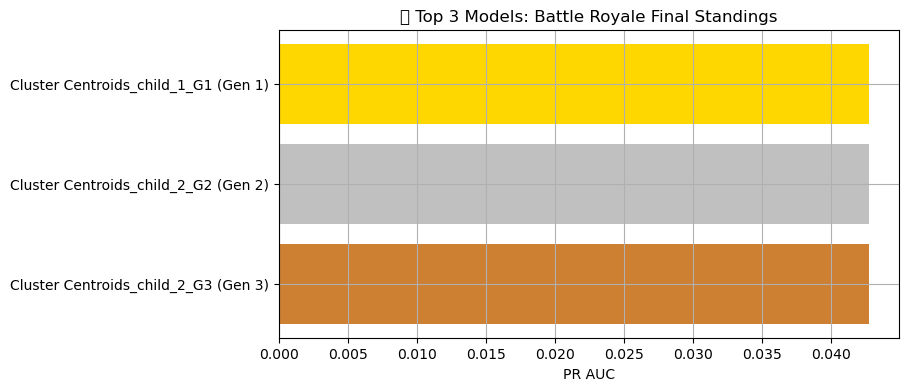

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

podium_df = pd.DataFrame([
    {
        "Name": f"{entry['label']} (Gen {entry['generation']})",
        "PR AUC": entry["score"]["pr_auc"]
    }
    for entry in final_results[:3]
])

podium_df = podium_df[::-1]  # So the best is on top visually

plt.figure(figsize=(8, 4))
bars = plt.barh(podium_df["Name"], podium_df["PR AUC"], color=["#cd7f32", "#c0c0c0", "#ffd700"])
plt.title("🏆 Top 3 Models: Battle Royale Final Standings")
plt.xlabel("PR AUC")
plt.grid(True)
plt.show()